# Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, \
GradientBoostingClassifier

In [2]:
threads = pd.read_csv("../data/cleaned_threads.csv")

# Target

In [3]:
target = threads["num_comments"].median()
print(f"Target is threads with more than {target} comments.")

Target is threads with more than 55.0 comments.


# EDA & Feature Engineering
----

### Thread Types
----
- `text_thread` - thread contains text
- `title_thread` - thread only contains title
- `pic_thread` - thread only contains picture
- `link_thread` - thread only contains a link
- `video_thread` - thread only contains a video

In [4]:
#thread with text
threads["text_thread"] = np.where(((threads["post_hint"] == "text") & (threads["selftext"] != "None") |
                                   (threads["post_hint"] == "self") & (threads["selftext"] != "None")),
                                   1, 0)
#title Only
threads["title_thread"] = np.where((threads["post_hint"] == "text") & (threads["selftext"] == "None"),
                                   1, 0)
#picture only
threads["pic_thread"] = np.where((threads["post_hint"] == "image"), 1, 0)

#link only
threads["link_thread"] = np.where((threads["post_hint"] == "link"), 1, 0)

#video only
threads["video_thread"] = np.where(((threads["post_hint"] == "hosted:video") |
                                  (threads["post_hint"] == "rich:video")), 1, 0)

### Text Lengths and Word Counts
----
- `title_length` - length of the title
- `title_words` - number of words in the title. Does not remove stop words.
- `text_length` - length of the text
- `text_words` - number of words in the text. Does not remove stop words.

In [5]:
threads["title"] = np.where(threads["title"].isnull(), "i", threads["title"])
threads["title_length"] = threads["title"].str.len()
threads["title_words"] = threads["title"].str.split().str.len()
threads["text_length"] = np.where(threads["selftext"] != "None", threads["selftext"].str.len(), 0)
threads["text_words"] = np.where(threads["selftext"] != "None",
                                 threads["selftext"].str.split().str.len(),
                                 0)

### Number of Times the Subreddit was Popular
----
Create a dictionary of times the subreddit appears in the dataset. If they are on a subreddit that is commonly interactive then it is likely that future posts will be interactive as well.

dictionary format -

subreddit : number of times they appear

In [6]:
#create a dictionary of subreddits
subreddit_count = dict(zip(threads["subreddit"].value_counts().index.tolist(),
         threads["subreddit"].value_counts()))
#map the dictionary based on threads["subreddit"]
threads["subreddit_count"] = threads["subreddit"].map(subreddit_count)

### Creation Time
----
Hours that threads are posts may effect thread popularity. Threads which are posted between 02:00 - 06:00 EST will have a limited US audience and might get overlooked. Other time slots will have their own limitations on audience.

Classification Breakdown:

| name | hour range | assigned value |
| ---- | ---------- | -------------- |
| overnight | 02:00 - 06:00 | 0 |
| morning | 06:00 - 11:00 | 1 |
| afternoon | 11:00 - 17:00 | 2 |
| evening | 17:00 - 22:00 | 3 |
| overnight | 22:00 - 02:00 | 4 |

(Note: name is not utilized in the model)

In [7]:
def map_created_hour(hour):
    if isinstance(hour, datetime.datetime):            
        hour = hour.hour
        if hour < 2:
            return 4
        if hour < 6:
            return 0
        if hour < 11:
            return 1
        if hour < 17:
            return 2
        if hour < 22:
            return 3
        if hour < 24:
            return 4
    else:
        print("Error: not a datetime value")

In [8]:
#ensure created_utc is a datetime object
threads["created_utc"] = pd.to_datetime(threads["created_utc"])
#map a classification based on the hour they were posted.
threads["creation_time"] = threads["created_utc"].map(map_created_hour)

# Target Param
----

In [9]:
def determine_targets(num_comments_list, target_list):
    """Returns a target integer based on which quartile the number of comments is.
    0-9    : 0
    10-24  : 1
    25-49  : 2
    50-74  : 3
    75-89  : 4
    90-100 : 5"""
    targets = []
    target_list[::-1]
    
    for num_comments in num_comments_list:
        for i, value in enumerate(target_list):
            if num_comments < value:
                targets.append(i)
                break
        else:
            targets.append(len(target_list))
    return targets

In [10]:
targets = threads["num_comments"].quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9]).values
threads["target"] = determine_targets(threads["num_comments"], targets)

In [11]:
threads["above_median"] = np.where(threads["num_comments"] > threads["num_comments"].median(),
                                   1, 0)

### Correlation Heatmap
----
Starting with a Correlation Heatmap to determine which features are worth focussing on.

These two are the main highlights and most likely to improve the model
- `time_on_reddit`
- `subreddit count`

The following are also noteworthy
- `num_comments` (`above_median` is derived from it and can't be used in modelling)
- `subreddit_subscribers` 
- `num_crossposts`
- `text_thread`

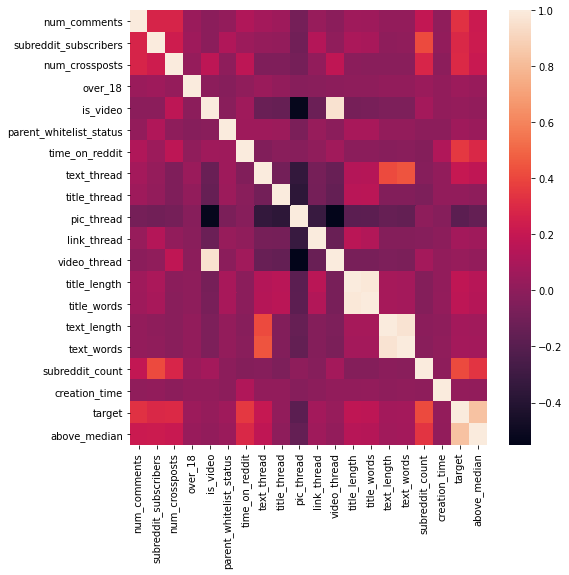

In [12]:
plt.figure(figsize=(8,8), facecolor="w")
sns.heatmap(threads.corr());

### Time on Reddit
----
There are two aspects to this which need to be considered.

1. The threads which are extremely popular in short times such as the two at the 20,000 second mark are technically outliers but in this case are the threads which we care about the most. These are explosive and directly popular.
2. Threads which are on reddit longer will naturally grow in post counts. On one hand this makes them less relevant but on the other hand the fact they have remained on r/popular over time means they have a form of endurance. These threads threads have endured and have features which keep them indirectly popular.

Both types of interactions should be featured and explained in the model.

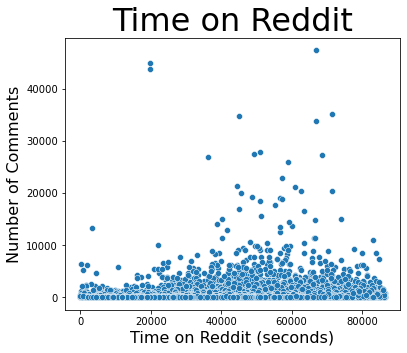

In [13]:
plt.figure(figsize=(6,5), facecolor="w")
sns.scatterplot(data=threads, x="time_on_reddit", y="num_comments")
plt.title('Time on Reddit', size=32)
plt.ylabel('Number of Comments', size=16)
plt.xlabel('Time on Reddit (seconds)', size=16);

### Dataset Appearances to Number of Comments
----
Despite this being a strong feature is is rather noisy.

It isn't really feasible to see the overall trend in the data, though, so a second rendering was created to plot the numbers of median comments by subreddit count at each quartile and see if there is an overall trend.

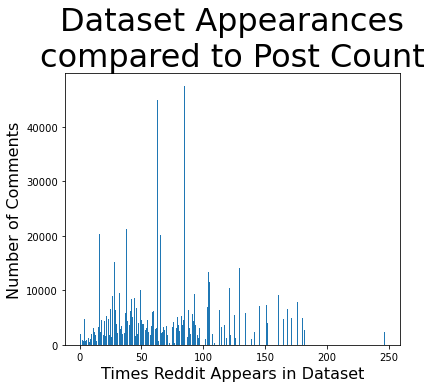

In [14]:
plt.figure(figsize=(6,5), facecolor="w")
plt.bar(threads["subreddit_count"], threads["num_comments"])
 
plt.title('Dataset Appearances\ncompared to Post Count', size=32)
plt.ylabel('Number of Comments', size=16)
plt.xlabel('Times Reddit Appears in Dataset', size=16);

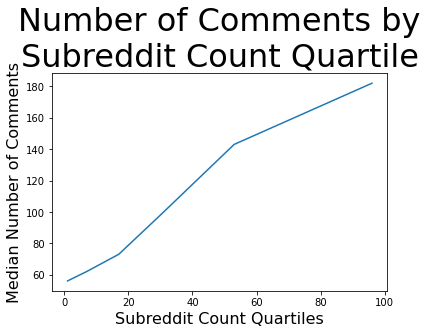

In [15]:
x = threads["subreddit_count"].quantile([0, 0.1, 0.25,0.5,0.75, 0.9])
y = [threads[threads["subreddit_count"] > i]["num_comments"].median() for i in x]

plt.figure(figsize=(6,4), facecolor="w")
plt.plot(x, y)
 
plt.title('Number of Comments by\nSubreddit Count Quartile', size=32)
plt.ylabel('Median Number of Comments', size=16)
plt.xlabel('Subreddit Count Quartiles', size=16);

### Parent Whitelist Status
----
This was not the one of the strongest correlations in the data but as marketing plays a huge role for Reddit there needed to be some exploration into how ad approval affects whether the post will get comments.

As it turns out there is still relevant information especially for a classification model. There are two clear categories on display in this visualization between allowing all ads and not allowing ads and the model should be able to utilize this data.

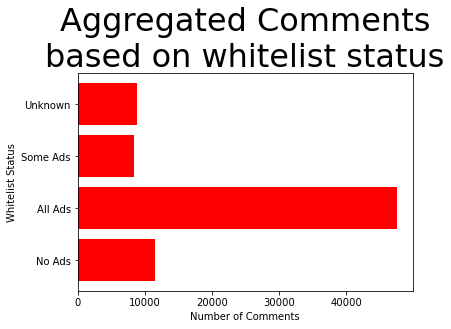

In [16]:
text = {3 : "All Ads",
        2 : "Some Ads",
        1 : "No Ads",
        0 : "Unknown"}
y = threads['parent_whitelist_status'].map(text)

plt.figure(figsize=(6,4), facecolor="w")
plt.barh(y, threads['num_comments'], align='center', color="r")
plt.title('Aggregated Comments\nbased on whitelist status', size=32)
plt.ylabel('Whitelist Status')
plt.xlabel('Number of Comments');

### Number of Crossposts
----
This visualization depicts several classes being formed between 0-1M Subscribers, 1-2M Subscribers and around 3 and 4M subscribers. The green line shows the median post counts at given ranges of subscribers.

I also added in an additional hue of whether the thread has text or not as that 

KNN and Random Forest Classifiers will use these groupings to make more accurate predictions.

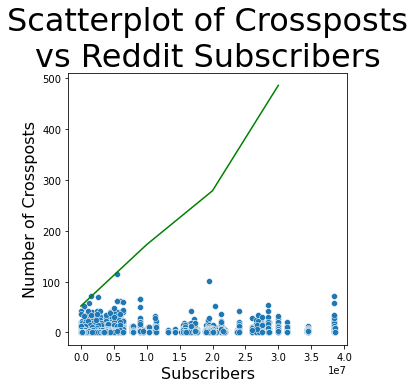

In [17]:
x = np.arange(0, 5) * (10 ** 7)
median_posts = [threads[(threads["subreddit_subscribers"] >= i) &
                (threads["subreddit_subscribers"] <= i+x[1])]["num_comments"].median()
                for i in x]

plt.figure(figsize=(5,5), facecolor="w")
sns.scatterplot(data=threads, x="subreddit_subscribers", y="num_crossposts")
plt.plot(x, median_posts, color="g")

plt.title('Scatterplot of Crossposts\nvs Reddit Subscribers', size=32)
plt.ylabel('Number of Crossposts', size=16)
plt.xlabel('Subscribers', size=16);

# KNN Model
----
Based on EDA there shouldn't be any issues designing classification models witht he data I collected.

### Baseline Score
----
If a random thread was drawn from a hat we could expect the thread to be above the median thread count 50.22% of the time.

In [18]:
baseline = 1 - threads["above_median"].mean()
print(f"Baseline Score: {baseline:.2%}")

Baseline Score: 50.22%


## KNN Model 1 (Simple)
----
Default Model with just pulled information required for project. No feature engineering.

With a score of 68.92% +- 0.30% this is a signifigant improvement over the baseline score of 50.22% with just the basic setup.

In [19]:
features = ['subreddit_subscribers', 'time_on_reddit', 'title_length']

In [20]:
X = threads[features]
y = threads["above_median"]

knn = KNeighborsClassifier()
ss = StandardScaler()
Xs = ss.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
simple_scores = cross_val_score(knn, Xs, y, cv=cv)

print(f"Simple Score: {simple_scores.mean():.2%} +- {simple_scores.std():.2%}")

Simple Score: 66.71% +- 0.35%


## KNN Model 2 (Includes Gridsearch and Feature Engineering)
----
Added a GridSearch and engineered features.

I opted to keep the K Values low. Ideally the K Value of this size of dataset should be 244 (square root of N) but this is just far too computationally intensive for this task. KNN is a great classifier but falls off on larger and more complex datasets.

We can see this reflected by only getting a modest improvement despite adding additional criteria which should help the classification metrics.

----

Simple Score: 68.92% +- 0.30%

GSCV Score: 75.18% +- 0.27%

In [21]:
features = ['subreddit_subscribers', 'num_crossposts',
            'parent_whitelist_status', 'time_on_reddit', 'text_thread',
            'title_thread', 'pic_thread', 'link_thread', 'video_thread',
            'title_length', 'text_length', 'title_words', 'text_words',
            'creation_time', 'subreddit_count']

In [22]:
X = threads[features]
y = threads["above_median"]

knn = KNeighborsClassifier()
ss = StandardScaler()
Xs = ss.fit_transform(X)

params = {"n_neighbors": [30],
          "weights": ["uniform", "distance"],
          "n_jobs": [-1]}
knn_gscv = GridSearchCV(knn, params, cv=5)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kgscv_scores = cross_val_score(knn_gscv, Xs, y, cv=cv)

print(f"GSCV Score: {kgscv_scores.mean():.2%} +- {kgscv_scores.std():.2%}")

GSCV Score: 75.18% +- 0.27%


## Random Forest
----

Surprisingly the Random Forest actually only showed a modest improvement over the KNN model.

Random Forest should be a superior model but without further exploration it is hard to prove which is. The random Forrest is less prone to overfitting so despite scoring similarly the Random Forest model is likely be far superior in practical applications.

----

RF GSCV Score: 76.97% +- 0.35%

In [23]:
features = ['subreddit_subscribers', 'num_crossposts', 'over_18',
            'parent_whitelist_status', 'time_on_reddit', 'text_thread',
            'title_thread', 'pic_thread', 'link_thread', 'video_thread',
            'title_length', 'text_length', 'title_words', 'text_words',
            'creation_time', "subreddit_count"]

In [24]:
X = threads[features]
y = threads["above_median"]

rf = RandomForestClassifier()
ss = StandardScaler()
Xs = ss.fit_transform(X)

params = {"n_estimators": [250],
          "criterion": ["gini", "entropy"],
          "bootstrap":[True, False],
          "n_jobs": [-1],
          "random_state": [42]}
rf_gscv = GridSearchCV(rf, params, cv=5)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfgscv_scores = cross_val_score(rf_gscv, Xs, y, cv=cv)

print(f"RF GSCV Score: {rfgscv_scores.mean():.2%} +- {rfgscv_scores.std():.2%}")

RF GSCV Score: 76.97% +- 0.35%


# Conclusions without NLP
----
Based in the information gathered from Reddit the features which are most predictive of a threads interaction, based on the number of comments, are:

| Feature | Effect |
| ------- | ------ |
| subreddit_subscribers | As subscriptions increase, p of above_median increases |
| num_crossposts | As crossposts increase, p of above_median increases |
| time_on_reddit | As time on r/popular increases, p of above_median increases |
| text_thread | If text_thread, p of above_median inccreases (modest effect) |
| subreddit_count | As subreddit_count increases, p of above_median increases |

In order to develop a thread that increases interactions (as measured by number of comments) threads should:

- be posted on subreddits with high subscriptions
- be cross posted to multiple subreddits
- be a topic with explosive popularity or endure for several days with modest popularity
- be posted on one of the subreddits that consistently have high post counts

Examples of the last type are:

- r/memes - 246 appearances
- r/Superstonk - 182 appearances
- r/HolUp - 180 appearances
- r/shitposting - 180 appearances

# NLP
----
The next step will be to incorporate some NLP into the data. The Random Forest functions at a pretty signifigant improvement over the baseline score but by incorporating NLP we should see signifigant improvements on that score. Outputting the data new dataset and separating NLP into it's own notebook.

In [26]:
features = ['subreddit', 'title', 'num_comments', 'selftext', 'subreddit_subscribers',
            'num_crossposts', 'over_18', 'parent_whitelist_status', 'time_on_reddit',
            'text_thread', 'title_thread', 'pic_thread', 'link_thread', 'video_thread',
            'title_length', 'text_length', 'title_words', 'text_words',
            'creation_time',"above_median", "subreddit_count"]

In [27]:
threads[features].to_csv("../data/threads_for_nlp.csv", index=False)